Ekstraksi fitur


In [3]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import tsfel 
import warnings

# Mengabaikan peringatan dari TSFEL atau Librosa jika ada
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
# SESUAIKAN PATH INI ke folder 'data/dataset-audio' Anda
DATASET_PATH = "C:\\Dokumen\\PSD\\voice\\data\\dataset-audio"
# Tentukan perintah yang ada di dalam folder setiap speaker
COMMANDS = ["buka", "tutup"] 
OUTPUT_CSV = "voice_features_RAW.csv" # File output untuk semua fitur

# Siapkan konfigurasi TSFEL
try:
    cfg = tsfel.get_features_by_domain()
    print(f"Konfigurasi TSFEL berhasil dimuat.")
except Exception as e:
    print(f"Error saat memuat konfigurasi TSFEL: {e}")
    cfg = None

def extract_tsfel_features(file_path, cfg):
    """Memuat file audio dan mengekstrak fitur TSFEL."""
    try:
        audio, sr = librosa.load(file_path, sr=None)
        # verbose=0 untuk mematikan progress bar internal TSFEL
        features_df = tsfel.time_series_features_extractor(cfg, audio, fs=sr, verbose=0) 
        return features_df
    except Exception as e:
        print(f"Error memproses {file_path}: {e}")
        return None

# --- Main Execution (BAGIAN YANG DIPERBARUI) ---
if cfg is not None:
    all_data_dfs = [] 
    print(f"Memulai ekstraksi fitur TSFEL dari {DATASET_PATH}...")

    # 1. Dapatkan daftar speaker (Abdi, Alex, dll.)
    try:
        # Mengambil semua folder di dalam DATASET_PATH
        speakers = [s for s in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, s))]
    except FileNotFoundError:
        print(f"Error: Path dataset {DATASET_PATH} tidak ditemukan. Harap periksa variabel DATASET_PATH.")
        speakers = []
        
    if not speakers:
        print(f"Tidak ada folder speaker ditemukan di {DATASET_PATH}")
    else:
        print(f"Ditemukan speakers: {speakers}")

    # 2. Loop baru: Speaker -> Command -> File
    for speaker in speakers:
        speaker_path = os.path.join(DATASET_PATH, speaker)
        
        for command in COMMANDS:
            command_path = os.path.join(speaker_path, command)
            
            # Periksa apakah folder .../Abdi/buka ada
            if not os.path.isdir(command_path):
                print(f"Melewatkan: {command_path} (tidak ditemukan)")
                continue # Lanjut ke command berikutnya

            files = [f for f in os.listdir(command_path) if f.endswith('.wav')]
            
            # 3. Buat label gabungan: "Abdi_buka", "Alex_tutup", dll.
            combined_label = f"{speaker}_{command}" 

            # Tampilkan progress bar untuk label gabungan
            for file_name in tqdm(files, desc=f"Memproses {combined_label}"):
                file_path = os.path.join(command_path, file_name)
                features_df = extract_tsfel_features(file_path, cfg)
                
                if features_df is not None:
                    # 4. Simpan label gabungan
                    features_df['label'] = combined_label 
                    all_data_dfs.append(features_df)

    print("\nEkstraksi fitur selesai.")

    # Gabungkan semua DataFrame menjadi satu
    if all_data_dfs:
        data = pd.concat(all_data_dfs, ignore_index=True)
        print(f"Data asli diekstrak: {data.shape[0]} baris, {data.shape[1]} kolom (termasuk label)")
        print("\nContoh label yang diekstrak:")
        print(data['label'].value_counts()) # Tampilkan jumlah data per kelas

        # --- Pembersihan Data Awal ---
        data.fillna(0, inplace=True)
        non_variant_cols = [col for col in data.columns if col != 'label' and data[col].nunique() == 1]
        
        if non_variant_cols:
            print(f"Menghapus {len(non_variant_cols)} kolom konstan...")
            data.drop(columns=non_variant_cols, inplace=True)
            
        print(f"Data setelah pembersihan: {data.shape[0]} baris, {data.shape[1]} kolom")

        # --- Simpan ke CSV ---
        data.to_csv(OUTPUT_CSV, index=False)
        print(f"Berhasil! Data fitur mentah telah disimpan ke {OUTPUT_CSV}")

    else:
        print("Tidak ada data yang berhasil diekstrak.")
else:
    print("Ekstraksi fitur dibatalkan karena konfigurasi TSFEL gagal dimuat.")

Konfigurasi TSFEL berhasil dimuat.
Memulai ekstraksi fitur TSFEL dari C:\Dokumen\PSD\voice\data\dataset-audio...
Ditemukan speakers: ['Abdi', 'Alex']


Memproses Alex_tutup: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]



Ekstraksi fitur selesai.
Data asli diekstrak: 400 baris, 157 kolom (termasuk label)

Contoh label yang diekstrak:
label
Abdi_buka     100
Abdi_tutup    100
Alex_buka     100
Alex_tutup    100
Name: count, dtype: int64
Menghapus 11 kolom konstan...
Data setelah pembersihan: 400 baris, 146 kolom
Berhasil! Data fitur mentah telah disimpan ke voice_features_RAW.csv


Memuat data dari voice_features_RAW.csv...
Label berhasil di-encode.

Memulai visualisasi PCA 3D...
Menjalankan StandardScaler...
Menjalankan PCA (n_components=3)...
Membuat plot PCA 3D...
Plot PCA 3D berhasil disimpan ke pca_visualization_3D_RAW.png

Menghitung skor Information Gain (Mutual Information)...
Perhitungan skor selesai.

Total fitur awal: 145
Fitur dengan skor 0 (di-drop): 15
Fitur relevan (skor > 0): 130

Daftar nama fitur ter-ranking (total 130) disimpan ke ranked_feature_list.pkl
Berhasil! Data fitur relevan telah disimpan ke voice_features_RELEVANT.csv


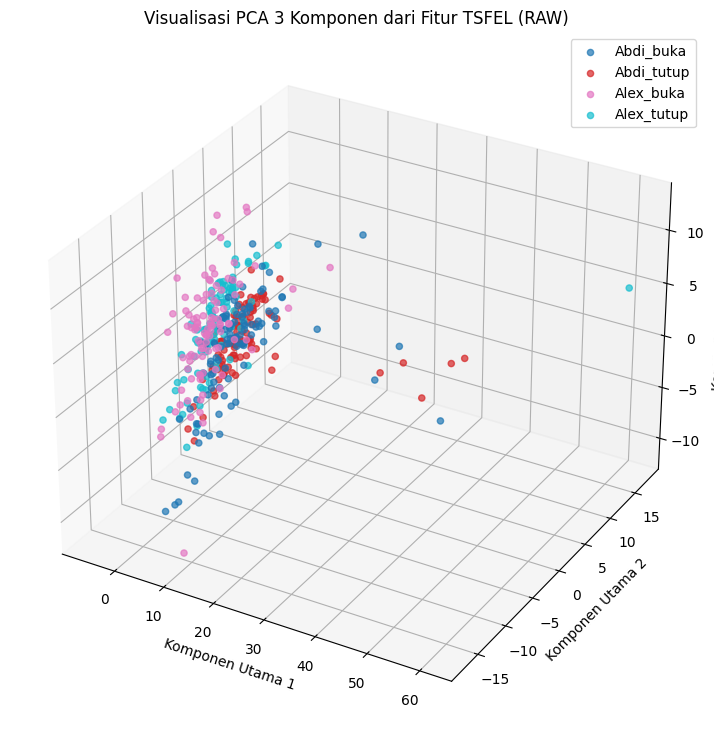

In [6]:
import pandas as pd
import numpy as np
import joblib 
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif

# --- BARU: Import untuk Visualisasi PCA ---
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D # (Tidak perlu di-import eksplisit lagi)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# -------------------------------------------

# --- Konfigurasi ---
INPUT_CSV = "voice_features_RAW.csv"
OUTPUT_CSV = "voice_features_RELEVANT.csv" 
RANKED_LIST_PKL = "ranked_feature_list.pkl" 

# --- Main Execution ---
print(f"Memuat data dari {INPUT_CSV}...")
try:
    data = pd.read_csv(INPUT_CSV)
except FileNotFoundError:
    print(f"Error: File {INPUT_CSV} tidak ditemukan.")
    print("Pastikan Anda sudah menjalankan skrip '1_ekstraksi_fitur.py' terlebih dahulu.")
    exit()

# --- 1. Pisahkan Fitur (X) dan Label (y) ---
X = data.drop('label', axis=1)
y = data['label']
feature_names = X.columns 

# --- 2. Encode Label ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Label berhasil di-encode.")

# -----------------------------------------------------------------
# --- BARU: Visualisasi PCA (Principal Component Analysis) 3D ---
# -----------------------------------------------------------------
print("\nMemulai visualisasi PCA 3D...")

# a. Standarisasi Fitur
print("Menjalankan StandardScaler...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# b. Terapkan PCA (BARU: n_components=3)
print("Menjalankan PCA (n_components=3)...")
pca = PCA(n_components=3) # <--- DIUBAH
pca_components = pca.fit_transform(X_scaled)

# c. Buat DataFrame PCA (BARU: 3 kolom)
pca_df = pd.DataFrame(
    data=pca_components, 
    columns=['PCA 1', 'PCA 2', 'PCA 3'] # <--- DIUBAH
)

# d. Tambahkan label asli ('buka', 'tutup') untuk pewarnaan
pca_df_final = pd.concat([pca_df, y.reset_index(drop=True)], axis=1)

print("Membuat plot PCA 3D...")
# e. Buat dan Simpan Scatter Plot 3D (BLOK PLOTTING BARU)
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d') # <--- Buat axis 3D

# Beri warna unik untuk setiap label
labels = pca_df_final['label'].unique()
colors = plt.cm.get_cmap('tab10', len(labels)) # 'tab10', 'jet', 'viridis'
color_map = {label: colors(i) for i, label in enumerate(labels)}

# Plot setiap grup label secara terpisah untuk membuat legenda
for label, color in color_map.items():
    subset = pca_df_final[pca_df_final['label'] == label]
    ax.scatter(
        subset['PCA 1'], 
        subset['PCA 2'], 
        subset['PCA 3'], 
        c=[color], # Matplotlib butuh 'c' sebagai list untuk 1 warna
        label=label, 
        alpha=0.7
    )

ax.set_title('Visualisasi PCA 3 Komponen dari Fitur TSFEL (RAW)')
ax.set_xlabel('Komponen Utama 1')
ax.set_ylabel('Komponen Utama 2')
ax.set_zlabel('Komponen Utama 3') # <--- Label Z
ax.legend(loc='best')
plt.grid(True)

# Simpan plot
pca_plot_filename = "pca_visualization_3D_RAW.png"
plt.savefig(pca_plot_filename)
print(f"Plot PCA 3D berhasil disimpan ke {pca_plot_filename}\n")
# -----------------------------------------------------------------
# --- AKHIR DARI BLOK PCA ---
# -----------------------------------------------------------------


# --- 3. Hitung Skor Information Gain (Mutual Info) ---
print("Menghitung skor Information Gain (Mutual Information)...")
mi_scores = mutual_info_classif(X, y_encoded, random_state=42)
print("Perhitungan skor selesai.")

# --- 4. Rangking Fitur dan Drop Skor 0 ---
feature_scores = pd.Series(mi_scores, index=feature_names).sort_values(ascending=False)
relevant_features = feature_scores[feature_scores > 0]
dropped_features_count = len(feature_scores) - len(relevant_features)

print(f"\nTotal fitur awal: {len(feature_scores)}")
print(f"Fitur dengan skor 0 (di-drop): {dropped_features_count}")
print(f"Fitur relevan (skor > 0): {len(relevant_features)}\n")

# --- 5. Simpan Daftar Fitur Ter-ranking ---
ranked_feature_list = relevant_features.index.tolist()
joblib.dump(ranked_feature_list, RANKED_LIST_PKL)
print(f"Daftar nama fitur ter-ranking (total {len(ranked_feature_list)}) disimpan ke {RANKED_LIST_PKL}")

# --- 6. Buat DataFrame Baru dan Simpan ---
final_columns = ranked_feature_list + ['label']
data_final = data[final_columns]
data_final.to_csv(OUTPUT_CSV, index=False)
print(f"Berhasil! Data fitur relevan telah disimpan ke {OUTPUT_CSV}")

Memuat data dari voice_features_RELEVANT.csv...
Label encoder disimpan ke label_encoder.pkl
Data dibagi: 320 latih, 80 uji.

Memulai iterasi training dari 130 fitur hingga 1 fitur...


Mencari Fitur Terbaik: 100%|██████████| 130/130 [00:08<00:00, 14.73it/s]


Iterasi training selesai.

--- Hasil Analisis ---
Akurasi tertinggi adalah 98.75%
Didapatkan saat menggunakan Top 43 fitur.
------------------------

Membuat visualisasi statistik akurasi...
Plot statistik disimpan ke akurasi_vs_fitur.png

Melatih model FINAL dengan Top 43 fitur terbaik...
Model final selesai dilatih.
Model final disimpan ke model_klasifikasi_TERBAIK.pkl
Daftar 43 fitur terbaik disimpan ke selected_features_TERBAIK.pkl

Memulai visualisasi PCA 3D untuk fitur-fitur terbaik...
Membuat plot PCA final 3D...
Plot PCA final 3D berhasil disimpan ke pca_visualization_3D_TERBAIK.png

--- Proses Selesai ---


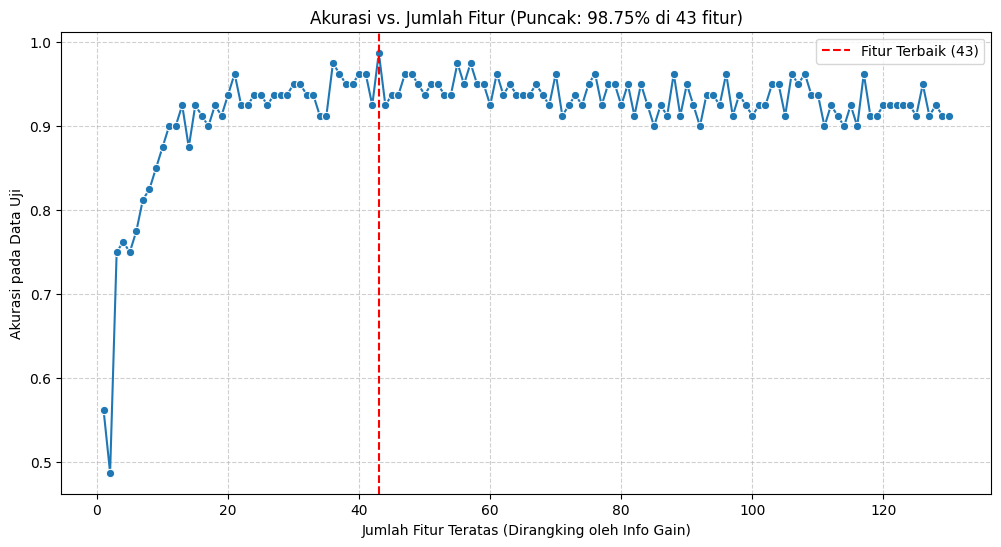

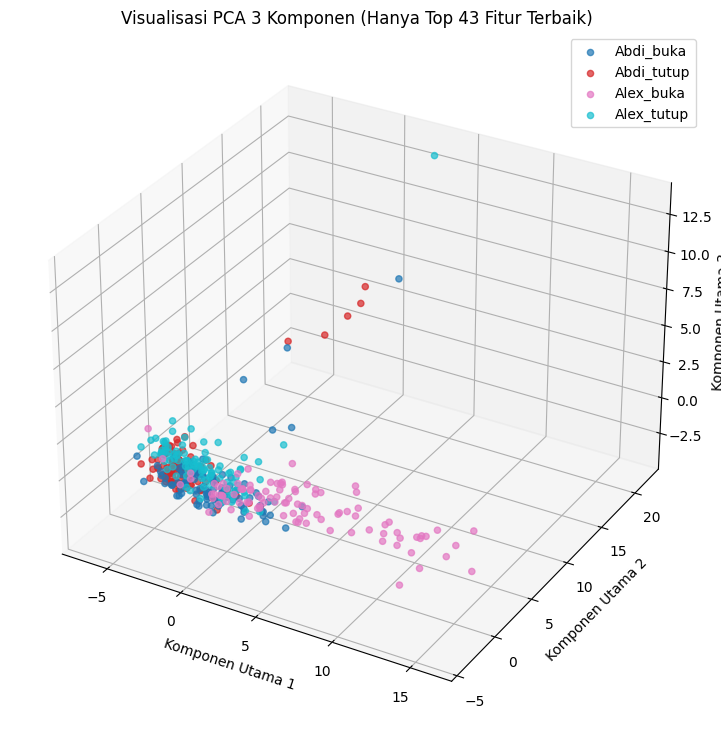

In [7]:
import pandas as pd
import joblib
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns # <-- Dibiarkan untuk plot akurasi
from tqdm import tqdm 
import warnings

# --- BARU: Import untuk PCA ---
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# -----------------------------

# Mengabaikan peringatan
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
INPUT_CSV = "voice_features_RELEVANT.csv" 
RANKED_LIST_PKL = "ranked_feature_list.pkl"   
MODEL_PKL = "model_klasifikasi_TERBAIK.pkl"     
FEATURES_PKL = "selected_features_TERBAIK.pkl"  
ENCODER_PKL = "label_encoder.pkl"           

# --- 1. Muat Data dan Daftar Fitur ---
print(f"Memuat data dari {INPUT_CSV}...")
try:
    data = pd.read_csv(INPUT_CSV)
    ranked_feature_list = joblib.load(RANKED_LIST_PKL)
except FileNotFoundError:
    print(f"Error: File {INPUT_CSV} atau {RANKED_LIST_PKL} tidak ditemukan.")
    print("Pastikan Anda sudah menjalankan skrip '2_seleksi_fitur.py' terlebih dahulu.")
    exit()
    
# --- 2. Pisahkan Fitur (X) dan Label (y) ---
X = data.drop('label', axis=1) 
y = data['label'] # Simpan label string ('buka', 'tutup') untuk plot

# --- 3. Encode Label ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)
joblib.dump(le, ENCODER_PKL) 
print(f"Label encoder disimpan ke {ENCODER_PKL}")

# --- 4. Bagi Data (Train/Test Split) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)
print(f"Data dibagi: {len(X_train)} latih, {len(X_test)} uji.")

# --- 5. Loop Training untuk Menemukan Fitur Terbaik ---
num_total_features = len(ranked_feature_list) 
accuracies = [] 
print(f"\nMemulai iterasi training dari {num_total_features} fitur hingga 1 fitur...")
for k in tqdm(range(num_total_features, 0, -1), desc="Mencari Fitur Terbaik"):
    current_features = ranked_feature_list[:k]
    X_train_subset = X_train[current_features]
    X_test_subset = X_test[current_features]
    model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    model.fit(X_train_subset, y_train)
    y_pred = model.predict(X_test_subset)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append((k, acc))
print("Iterasi training selesai.")

# --- 6. Analisis Hasil Iterasi ---
results_df = pd.DataFrame(accuracies, columns=['Num_Features', 'Accuracy'])
results_df = results_df.sort_values(by='Num_Features') 
best_result = results_df.loc[results_df['Accuracy'].idxmax()]
best_k = int(best_result['Num_Features'])
best_accuracy = best_result['Accuracy']
print(f"\n--- Hasil Analisis ---")
print(f"Akurasi tertinggi adalah {best_accuracy * 100:.2f}%")
print(f"Didapatkan saat menggunakan Top {best_k} fitur.")
print("------------------------\n")

# --- 7. Visualisasi Statistik Akurasi (Ini tetap 2D) ---
print("Membuat visualisasi statistik akurasi...")
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='Num_Features', y='Accuracy', marker='o') # <-- Plot ini pakai Seaborn
plt.title(f'Akurasi vs. Jumlah Fitur (Puncak: {best_accuracy*100:.2f}% di {best_k} fitur)')
plt.xlabel('Jumlah Fitur Teratas (Dirangking oleh Info Gain)')
plt.ylabel('Akurasi pada Data Uji')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Fitur Terbaik ({best_k})')
plt.legend()
plot_filename = "akurasi_vs_fitur.png"
plt.savefig(plot_filename)
print(f"Plot statistik disimpan ke {plot_filename}")

# --- 8. Latih dan Simpan Model FINAL ---
print(f"\nMelatih model FINAL dengan Top {best_k} fitur terbaik...")
final_feature_list = ranked_feature_list[:best_k]
X_final = X[final_feature_list] 
final_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
final_model.fit(X_final, y_encoded) 
print("Model final selesai dilatih.")
joblib.dump(final_model, MODEL_PKL)
print(f"Model final disimpan ke {MODEL_PKL}")
joblib.dump(final_feature_list, FEATURES_PKL)
print(f"Daftar {best_k} fitur terbaik disimpan ke {FEATURES_PKL}")


# -----------------------------------------------------------------
# --- 9. BARU: Visualisasi PCA Final 3D (dengan Fitur Terbaik) ---
# -----------------------------------------------------------------
print("\nMemulai visualisasi PCA 3D untuk fitur-fitur terbaik...")

# a. Standarisasi Fitur TERBAIK
scaler = StandardScaler()
X_final_scaled = scaler.fit_transform(X_final) # X_final dari langkah 8

# b. Terapkan PCA (BARU: n_components=3)
pca = PCA(n_components=3) # <--- DIUBAH
pca_components_final = pca.fit_transform(X_final_scaled)

# c. Buat DataFrame PCA (BARU: 3 kolom)
pca_df = pd.DataFrame(
    data=pca_components_final, 
    columns=['PCA 1', 'PCA 2', 'PCA 3'] # <--- DIUBAH
)

# d. Tambahkan label asli ('buka', 'tutup') untuk pewarnaan
pca_df_final = pd.concat([pca_df, y.reset_index(drop=True)], axis=1)

print("Membuat plot PCA final 3D...")
# e. Buat dan Simpan Scatter Plot 3D (BLOK PLOTTING BARU)
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d') # <--- Buat axis 3D

# Beri warna unik untuk setiap label
labels = pca_df_final['label'].unique()
colors = plt.cm.get_cmap('tab10', len(labels)) 
color_map = {label: colors(i) for i, label in enumerate(labels)}

# Plot setiap grup label secara terpisah
for label, color in color_map.items():
    subset = pca_df_final[pca_df_final['label'] == label]
    ax.scatter(
        subset['PCA 1'], 
        subset['PCA 2'], 
        subset['PCA 3'], 
        c=[color], 
        label=label, 
        alpha=0.7
    )

ax.set_title(f'Visualisasi PCA 3 Komponen (Hanya Top {best_k} Fitur Terbaik)')
ax.set_xlabel('Komponen Utama 1')
ax.set_ylabel('Komponen Utama 2')
ax.set_zlabel('Komponen Utama 3') # <--- Label Z
ax.legend(loc='best')
plt.grid(True)

# Simpan plot
pca_plot_filename_final = "pca_visualization_3D_TERBAIK.png"
plt.savefig(pca_plot_filename_final)
print(f"Plot PCA final 3D berhasil disimpan ke {pca_plot_filename_final}\n")

print("--- Proses Selesai ---")